In [1]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)

/Users/louis/mambaforge/envs/dLux/lib/python3.10/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt
import equinox as eqx
import optax
import functools as ft # used for filtering
from tqdm.notebook import tqdm
import poppy

In [3]:
plt.figure() # this need to be run to make this work properly
plt.show()
plt.rcParams['figure.dpi'] = 120
plt.rcParams['image.cmap'] = 'hot'
plt.rcParams["text.usetex"] = 'true'
# plt.rcParams.keys()

<Figure size 432x288 with 0 Axes>

In [4]:
from dLux.base import *
from dLux.layers import *
from dLux.propagators import *

### To start, if you havent, please read over [our doccumetation](https://louisdesdoigts.github.io/dLux/) to get the basics of $\partial$Lux, primarily Layers and `OpticalSystem()`


---

# Optimising a single parameter!

We will start exploring the use of $\partial$Lux be optimising a single parameter. We will do this by generating a PSF using poppy and then fitting that PSF using a $\partial$Lux model.

The poppy example we will use models the PSF in the far-field regieme exclusinvely in angular units, and is therefore agnostic to focal length and pixelsize. We will guess approximate values for these paramters and then optimise our $\partial$Lux model to find the equivilent focal length based on our pixelsize value.

This poppy model is taken from this [link](https://poppy-optics.readthedocs.io/en/latest/figures/README%20Figure.html)

In [5]:
# Define parameter needed for poppy
wl = 1.5e-6
aperture = 2.4 
pixsize_arcsec = 0.013
fov_arcsec = 3.0
wf_npix = 1024       
det_npix = np.round(2*fov_arcsec/pixsize_arcsec).astype(int)

In [6]:
# Set up poppy optical system
hst_osys_p = poppy.OpticalSystem()
hst_aper = poppy.CompoundAnalyticOptic(opticslist=[
    poppy.SecondaryObscuration(secondary_radius=0.3, n_supports=4, support_width=0.1),
    poppy.CircularAperture(radius=aperture/2)])
hst_osys_p.add_pupil(hst_aper)
hst_osys_p.add_detector(pixelscale=pixsize_arcsec, fov_arcsec=fov_arcsec)

In [7]:
# Generate poppy PSF and get the aperture array to apply to our mode
hst_fits, intermediates = hst_osys_p.calc_psf(wl, return_intermediates=True)
hst_psf_p = np.flipud(np.flipud(hst_fits[0].data).T) # Flip to match ∂Lux
hst_ap = np.array(intermediates[0].amplitude) # Take aperture for ∂Lux
osamp = intermediates[-1].oversample

### Now we create out ∂Lux object

In [8]:
# Define approximate fl and pixelsize, we will optimise the fl to match poppy
fl = 57.6  # Approximate the fl, this is what we will learn
det_pixsize = 4e-9 # Approximate value, this will be fixed

hst_layers = [
    CreateWavefront     (wf_npix, wf_npix),
    MultiplyArray       (hst_ap),
    NormaliseWavefront  (),
    MFT                 (det_npix, fl, det_pixsize)]

wavels = np.array([wl])
hst = OpticalSystem(hst_layers, wavels=wavels)
psf = hst()

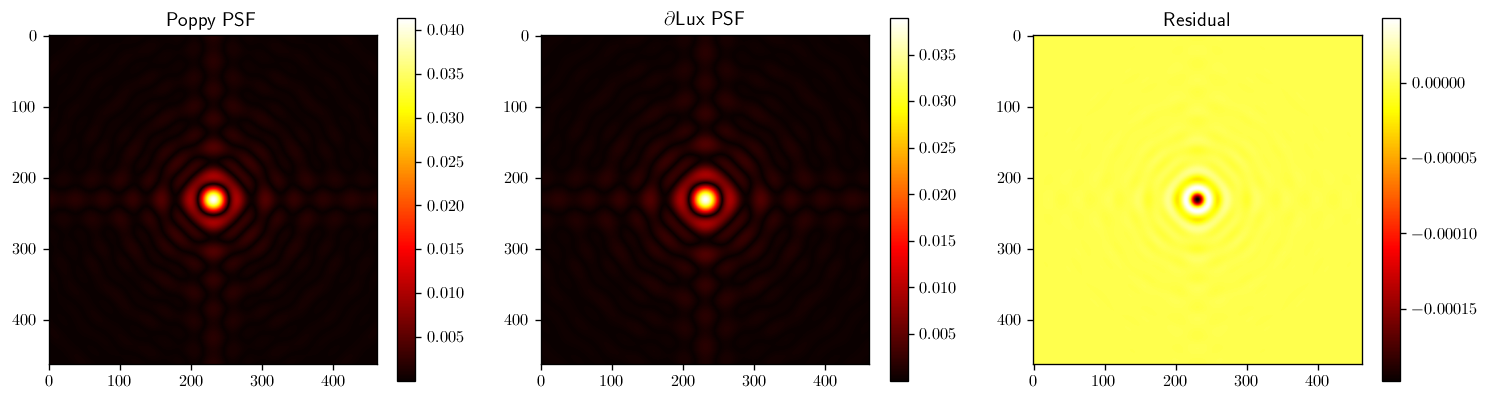

In [9]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title("Poppy PSF")
plt.imshow(hst_psf_p**0.5)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("$\partial$Lux PSF")
plt.imshow(psf**0.5)
plt.colorbar()

norm = psf - hst_psf_p
plt.subplot(1, 3, 3)
plt.title("Residual")
plt.imshow(norm)
plt.colorbar()
plt.show()

---

## Optimisation

So now we need to set up our optimisation objects. One major benfit of ∂Lux is that it allows us to use the optimsation package developed by the deep mind team, Optax. It does mean that we need to learn a little bit more about the different obects in order to get everything to play nicely.

Firstly we need to define which parameters we want to optimise, this is done by creating a 'filter_spec' object. This can be thought of as a binary mask defining which parameters to optimise, that is not applied to an array, but an arbitrary ∂Lux model. 

We initialise this by defaulting all values to False:
> ```filter_spec = jax.tree_map(lambda _: False, model)```

We can then change the individual paramaters we want to optimise to `True`. In this example we only want to optimise the focal length, so we use this syntax:
> ```filter_spec = eqx.tree_at(lambda scene: scene.layers[3].focal_length, filter_spec, replace=True)```

After that, all we need to do is define our loss function and pass the `filter_spec` to our loss function decorators, and initialise our optax algorithm. In this example we will use an adam optimiser with a learning rate of 100. This is relatively straightfoward and the synax of the next few cells can be applied generally to all single-parameter optimisations

In [10]:
# Set up Optimisation
filter_spec = jax.tree_map(lambda _: False, hst)
filter_spec = eqx.tree_at(lambda scene: scene.layers[3].focal_length, filter_spec, replace=True)

In [11]:
@eqx.filter_jit
@ft.partial(eqx.filter_value_and_grad, filter_spec=filter_spec)
def loss_func(model, data):
    out = model()
    return np.mean(np.square(data - out))

/Users/louis/mambaforge/envs/dLux/lib/python3.10/site-packages/equinox/grad.py:71: UserWarning: For brevity the `filter_spec` argument has been renamed `arg`
  warnings.warn("For brevity the `filter_spec` argument has been renamed `arg`")


In [12]:
%%time
_ = loss_func(hst, hst_psf_p) # Compile
print("Initial Loss: {}".format(_[0]))

Initial Loss: 2.8533691282551335e-11
CPU times: user 1.02 s, sys: 23.5 ms, total: 1.04 s
Wall time: 497 ms


In [13]:
optim = optax.adam(1e2)
opt_state = optim.init(hst)

In [14]:
model = OpticalSystem(hst_layers, wavels=wavels)
errors, grads_out, models_out = [], [], []
for i in tqdm(range(750)):
    loss, grads = loss_func(model, hst_psf_p)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    models_out.append(model)
    errors.append(loss)
    grads_out.append(grads)

  0%|          | 0/750 [00:00<?, ?it/s]

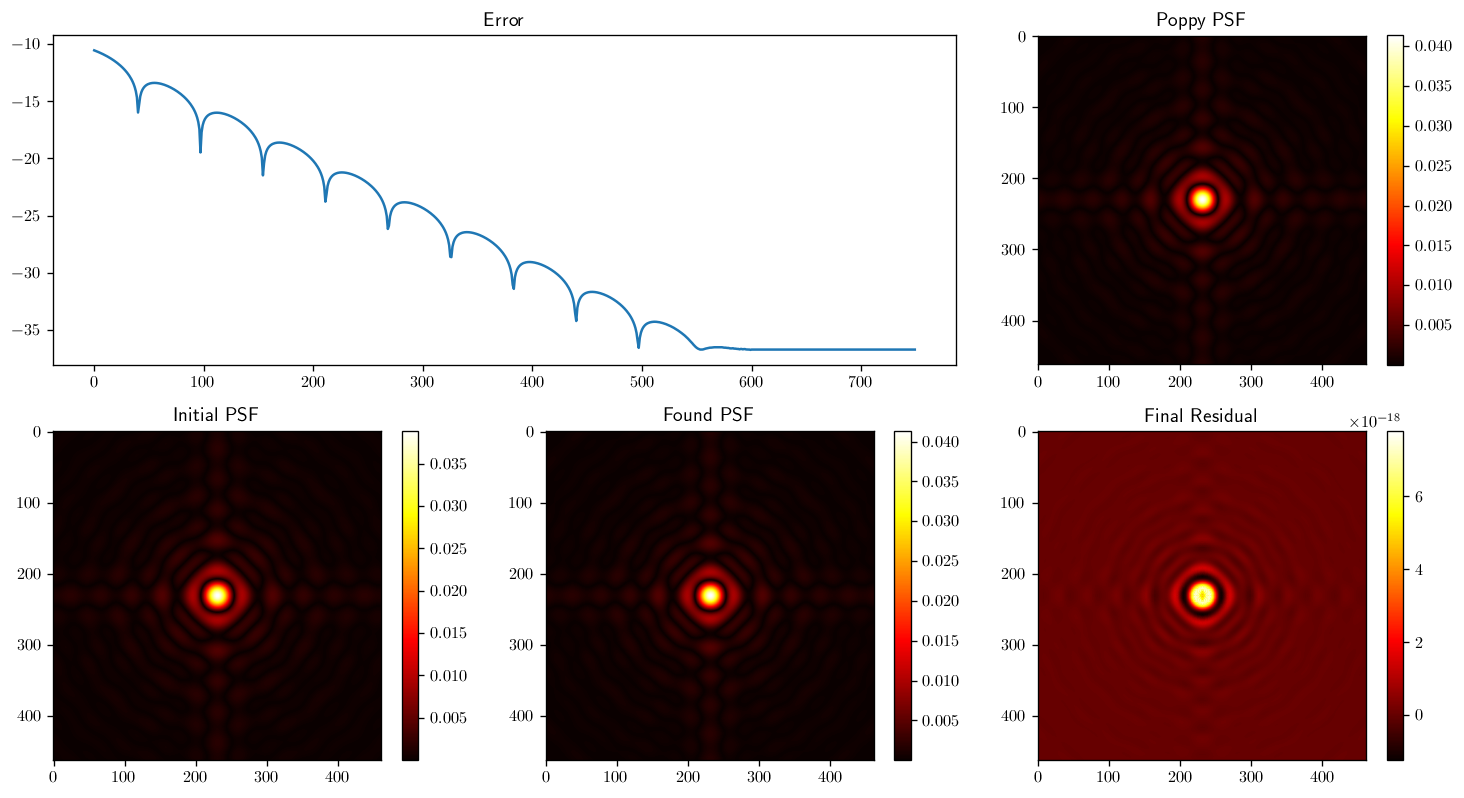

In [15]:
initial_psf = hst()
final_psf = model()

plt.figure(figsize=(15, 8))

plt.subplot(2, 3, (1,2))
plt.title("Error")
plt.plot(np.arange(len(errors)), np.log10(np.array(errors)))
# plt.plot(np.arange(len(errors)), np.array(errors))


plt.subplot(2, 3, 3)
plt.title("Poppy PSF")
plt.imshow(hst_psf_p**0.5)
plt.colorbar()

plt.subplot(2, 3, 4)
plt.title("Initial PSF")
plt.imshow(initial_psf**0.5)
plt.colorbar()

plt.subplot(2, 3, 5)
plt.title("Found PSF")
plt.imshow(final_psf**0.5)
plt.colorbar()

plt.subplot(2, 3, 6)
residual = hst_psf_p-final_psf
plt.title("Final Residual")
plt.imshow(residual)
plt.colorbar()
plt.show()

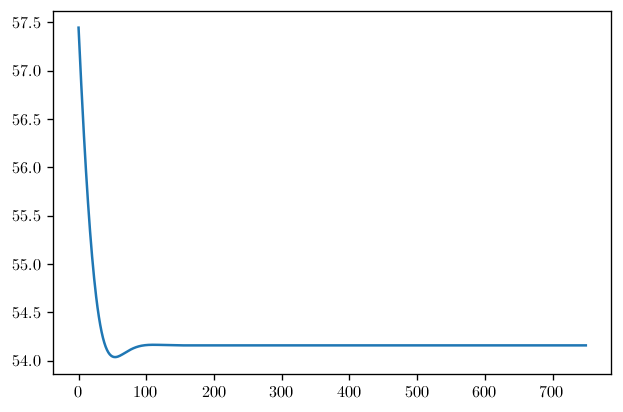

In [16]:
fls = [o.layers[3].focal_length for o in models_out]
# plt.plot(np.log10(np.array(fls)))
plt.plot(fls)

In [17]:
print(np.allclose(hst_psf_p, final_psf))

True


### Beauty! As we can see we have found the equivalent focal length required to match the poppy psf, and the difference between the two is at the machine precision level!